In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

%matplotlib inline

In [22]:
# Import the dataset
words = open('../names.txt', 'r').read().splitlines()
print(words[:10])

# Build the dict of all characters and map them to integers
chars = sorted(list(set(''.join(words))))
stoi = {c: i+1 for i, c in enumerate(chars)}
stoi['.'] = 0
itos = {i: c for c, i in stoi.items()}

print(len(words), itos)

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
32033 {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [26]:
# Compile the dataset for the neural network

## Define the context length: how many characters do we take to predict the next one?
block_size = 3
xs, ys = [], []

for word in words[:5]: # loading in only five test examples, but when training use the entire dataset
    context_window = [0] * block_size # just initializes the array according to block size, ex. [0, 0, 0]
    # context window for each word, which is the size of the word
    
    for ch in word + '.': # ie. this is the word with an end special character '.', so 'emma.'
        index = stoi[ch] # get the index of the character in the dictionary we created
        xs.append(context_window)
        ys.append(index) # store the label for previous round of context

        # create moving window of context according to the current character
        # ex. if the next character is a, index 1
        # emm -> mm + [1] = mma
        context_window = context_window[1:] + [index] # slides through the word to get chunks of three for training
        # print(''.join(itos[i] for i in context_window))
    
xs = torch.tensor(xs) # contains the input context
ys = torch.tensor(ys) # contains index of next character, predicted from xs

print(xs)
print(xs[0]) # ...
print(xs[1]) # ..e
print(xs[2]) # .em
print(xs[3]) # emm
print(xs[4]) # mma
print(xs[5]) # ...
print(xs[6]) # ..o # starting olivia


tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])
tensor([0, 0, 0])
tensor([0, 0, 5])
tensor([ 0,  5, 13])
tensor([ 5, 13, 13])
tensor([13, 13,  1])
tensor([0, 0, 0])
tensor([ 0,  0, 15])


In [29]:
# For reference, in Yoshua's paper he uses 'C' as the name for this table. Here, each of the 27 characters is represented by a 2-dimensional embedding

# My embedding lookup table basically contains row by row a representation of each row of my xs tensor, which is made up of three character context windows
# Makes for denser, lower-dimensional representations (only 2, vs 27)
embedding_lookup_table = torch.randn((27, 2))  
embedding = embedding_lookup_table[xs] 
print(embedding[4]) # mma

# F.one_hot does something a bit different. It contains a row by row representation of each row as well, but with sparse tensors of all zeros except for each char
x_enc = F.one_hot(xs, num_classes=27).float()
print(x_enc[4]) # mma


tensor([[ 0.6004, -2.3236],
        [ 0.6004, -2.3236],
        [-0.8058, -0.2392]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])


In [42]:
# Let's do this again, but assume we're just initializing weights and biases for one input layer feeding into the hidden layer

W1 = torch.randn((6, 100)) # the way we chose six is because we have a context of three characters, each with two dimensions
b1 = torch.randn(100) # matches the outputs

# getting the hidden layer
# hundred dimensional activations for each of our embedding examples
h = embedding.view(embedding.shape[0], 6) @ W1 + b1 # the @ is the matrix multiplication operator
h = torch.tanh(h)
h


tensor([[-0.9907, -0.0248, -0.9607,  ..., -0.9992, -0.9392,  0.3800],
        [-0.9963,  0.2508, -0.8857,  ..., -0.9988, -0.9404, -0.4448],
        [-0.9766, -0.5431, -0.3831,  ..., -0.9643,  0.9143, -0.2807],
        ...,
        [ 0.9990,  0.3637, -0.9781,  ..., -0.5663, -0.9987, -0.7543],
        [-0.1911,  0.5765, -0.8798,  ..., -0.9738, -0.9217,  0.9619],
        [-0.9994, -0.2852, -0.9872,  ..., -0.9994, -0.9569, -0.0236]])

In [52]:
# Now, initalize the output layer
W2 = torch.randn((100, 27)) # 100 is the number of hidden units outputted from the last layer, 27 is the number of characters possibilities
b2 = torch.randn(27) # again, matches the outputs

logits = h @ W2 + b2

In [ ]:
## This is a classification function, we can replace it with cross_entropy
# counts = logits.exp()
# probabilities = counts / counts.sum(1, keepdim=True)
# loss = -probabilities[torch.arange(32), ys].log().mean()

loss = F.cross_entropy(logits, ys)
loss

In [138]:
###### Let's set up our model! These are the drivers ######
g = torch.Generator().manual_seed(42)
embedding_lookup_table = torch.randn((27, 2), generator=g) # (weights)
W1 = torch.randn((6, 100), generator = g)
b1 = torch.randn(100, generator = g)
W2 = torch.randn((100, 27), generator = g)
b2 = torch.randn(27, generator = g)

parameters = [embedding_lookup_table, W1, b1, W2, b2]

In [88]:
sum(p.nelement() for p in parameters) # total number of parameters

3481

In [142]:
for p in parameters:
    p.requires_grad = True

# As a model grows in parameters, it becomes easier and easier to overfit
# Thus typically you split your dataset into three sets: training (80% - parameters), dev/validation (10% - hyperparameters), and test (10% -  evaluate loss on this sparingly or risk overfitting on this as well)
# Make sure loss is decreasing on the dev set, and then evaluate on the test set and one isn't overfitting

In [143]:
# Use this to try out different learning rates
lre = torch.linspace(-3, 1, 1000)
lrs = 10**lre
lrs

tensor([1.0000e-03, 1.0093e-03, 1.0186e-03, 1.0280e-03, 1.0376e-03, 1.0472e-03,
        1.0569e-03, 1.0667e-03, 1.0765e-03, 1.0865e-03, 1.0966e-03, 1.1067e-03,
        1.1170e-03, 1.1273e-03, 1.1378e-03, 1.1483e-03, 1.1589e-03, 1.1697e-03,
        1.1805e-03, 1.1915e-03, 1.2025e-03, 1.2136e-03, 1.2249e-03, 1.2362e-03,
        1.2477e-03, 1.2592e-03, 1.2709e-03, 1.2826e-03, 1.2945e-03, 1.3065e-03,
        1.3186e-03, 1.3308e-03, 1.3432e-03, 1.3556e-03, 1.3682e-03, 1.3808e-03,
        1.3936e-03, 1.4065e-03, 1.4196e-03, 1.4327e-03, 1.4460e-03, 1.4594e-03,
        1.4729e-03, 1.4865e-03, 1.5003e-03, 1.5142e-03, 1.5282e-03, 1.5424e-03,
        1.5567e-03, 1.5711e-03, 1.5856e-03, 1.6003e-03, 1.6151e-03, 1.6301e-03,
        1.6452e-03, 1.6604e-03, 1.6758e-03, 1.6913e-03, 1.7070e-03, 1.7228e-03,
        1.7388e-03, 1.7549e-03, 1.7711e-03, 1.7875e-03, 1.8041e-03, 1.8208e-03,
        1.8377e-03, 1.8547e-03, 1.8719e-03, 1.8892e-03, 1.9067e-03, 1.9244e-03,
        1.9422e-03, 1.9602e-03, 1.9783e-

In [141]:
lri = []
lossi = []

# Run gradient descent

for i in range(10000): #overfitting would be to set this to 1k learning cycles for example
    ## Make a mini batch
    # In this example, we will grab 32 rows of the lookup table
    ix = torch.randint(0, xs.shape[0], (32,))
    
    ## Forward pass
    embedding = embedding_lookup_table[xs[ix]] # Going row by row to feed in the data in batches
    h = torch.tanh(embedding.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, ys[ix])
    print(loss.item()) # gives just loss for this batch

    ## Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    ## Update
    # lr = lrs[i] # for when we are trying to find the optimum learning rate
    lr = 0.4
    for p in parameters:
        p.data += -lr * p.grad     

    # Track stats
    # lri.append(lre[i])
    # lossi.append(loss.item())

20.254974365234375
9.602680206298828
6.630841255187988
5.434675216674805
9.955889701843262
5.913910865783691
4.081821441650391
2.9586143493652344
3.774850606918335
2.575747489929199
2.0753092765808105
1.4694809913635254
1.4678027629852295
2.9143130779266357
1.930915117263794
0.8951557278633118
1.5940947532653809
1.1715319156646729
1.332185983657837
1.4892538785934448
0.8903496861457825
0.3606177568435669
0.3623799979686737
0.6263620257377625
0.32805919647216797
0.29290446639060974
0.8586003184318542
1.2871496677398682
1.0911080837249756
1.4863717555999756
1.7534774541854858
0.8063641786575317
0.6693124175071716
0.7269676327705383
0.2621666193008423
0.5525039434432983
0.4645557403564453
0.7024577260017395
0.30089783668518066
0.3683382570743561
0.5224819183349609
0.314518541097641
0.6807568669319153
0.5778849124908447
0.39340558648109436
0.05672311782836914
0.7966053485870361
1.078969955444336
0.28036201000213623
0.8209913372993469
0.25859251618385315
0.8498967289924622
1.023370265960693

In [137]:
## Getting the loss over the entire model

embedding = embedding_lookup_table[xs[ix]] # Going row by row to feed in the data in batches
h = torch.tanh(embedding.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, ys[ix])
loss

tensor(0.3114, grad_fn=<NllLossBackward0>)

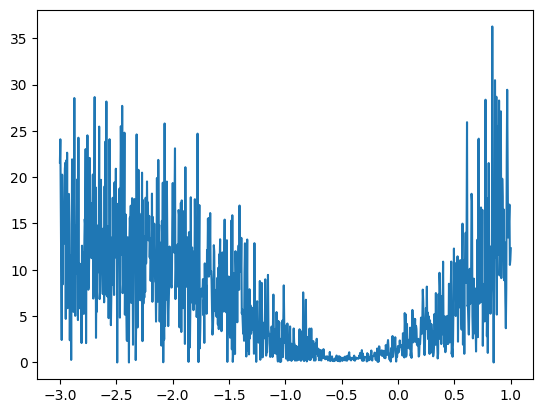

In [97]:
plt.plot(lri, lossi)

# It should be between -0.5 and 0 (more stable)